In [59]:
from librosa import load
import numpy as np
import IPython
from matplotlib import pyplot as plt

from src.recorte import recortar

Ejercicio 1

In [60]:
AUDIO = './assets/estocastico.wav'

audio_signal, fs = load(AUDIO, sr=None)
print(f'fs={fs}, audio_signal.shape={audio_signal.shape}')

IPython.display.Audio(audio_signal, rate=fs)

fs=44100, audio_signal.shape=(88200,)


Ejercicio 2

In [5]:
markers = recortar(audio_signal, fs)


FloatSlider(value=5000.0, description='Inicio:', max=83200.0, min=5000.0, step=100.0)

FloatSlider(value=6000.0, description='Fin:', max=83200.0, min=5000.0, step=100.0)

Button(description='Reproducir segmento', style=ButtonStyle())

Button(description='Agregar marcador', style=ButtonStyle())

Output()

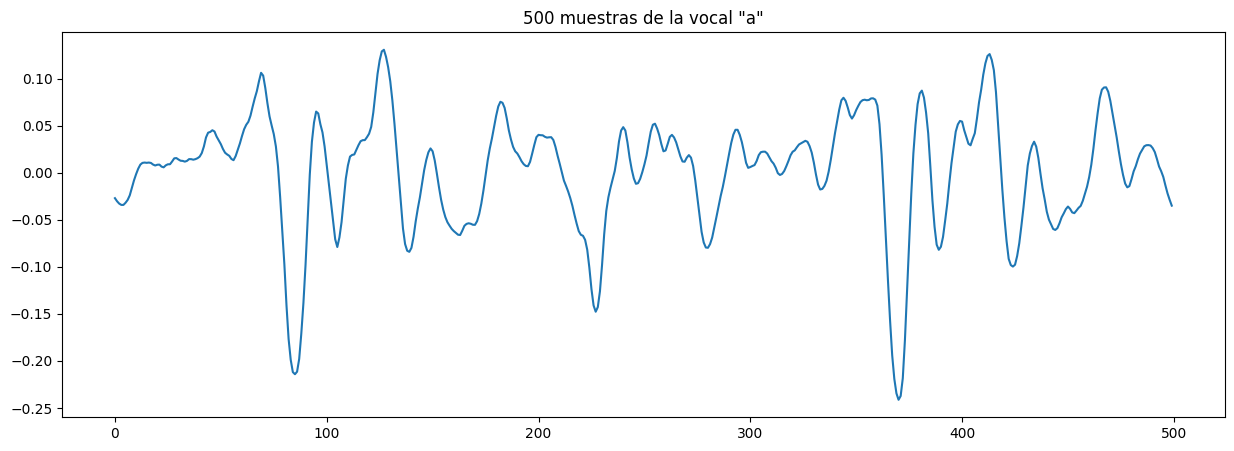

In [61]:
vowels = {
    'e':(28300, 32200), 
    'first_o':(40200, 44100), 
    'a':(47700, 49700), 
    'i':(58400, 60900), 
    'sec_o':(67200, 69200)}

a = audio_signal[vowels['a'][0]:vowels['a'][1]]

plt.figure(figsize=(15, 5))
plt.plot(a[500:1000])
plt.title('500 muestras de la vocal "a"')
plt.show()

Ejercicio 3

In [62]:
def lpc_compute(y: np.ndarray, order: int) -> np.ndarray:
    """
    Compute LPC coefficients.

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    order : int
        Order of the LPC.

    Returns
    -------
    np.ndarray
        LPC coefficients.

    Raises
    ------
    ValueError
        If matrix inversion fails. 
    """

    autocor = np.correlate(y, y, mode='full')
    autocor = autocor[len(autocor)//2:] # positive lags

    r = autocor[1:order + 1]

    # Correlation matrix
    R = np.zeros((order, order))
    R = np.array(
        [[autocor[abs(i - j)] for j in range(order)] for i in range(order)]
    )
    try:
        R_inv = np.linalg.inv(R)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix inversion failed.")
    
    return R_inv @ r

In [ ]:
# tomo 500 samples de la vocal "a"
vowel_a = audio_signal[vowels['a'][0]:vowels['a'][1]] # vowel "a"

signal = vowel_a[500:1000]  # 500 samples

h = lpc_compute(signal, order=len(signal) // 2)
print(f'LPC Coefficients: {h}')

Ejercicio 5

In [64]:
def excitation_signal(y: np.ndarray, lpc_coeffs: np.ndarray) -> np.ndarray:
    """
    Computes an excitation signal from the vowel and its LPC coefficients.

    Parameters
    ----------
    y : np.ndarray
        The input vowel signal.
    lpc_coeffs : np.ndarray
        The LPC coefficients.

    Returns
    -------
    np.ndarray
        Excitation signal.
    """
    # The excitation is the difference between the original and predicted
    return y - np.convolve(y, lpc_coeffs, mode='same')


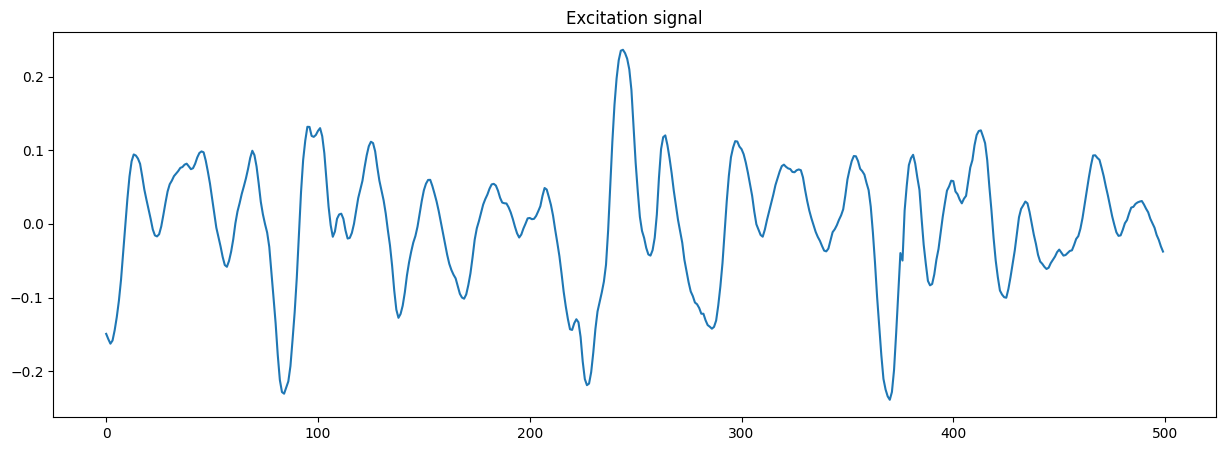

In [65]:
x_hat = excitation_signal(signal, h)
plt.figure(figsize=(15, 5))
plt.plot(x_hat)
plt.title('Excitation signal')
plt.show()

Ejercicio 9

Number of windows: 198
[ 1.06895261 -0.33373343  0.39979122 -0.68612109  0.58442223 -0.44130549
  0.35312821 -0.2447352   0.24034477 -0.18769802  0.10102404  0.05694296
 -0.07175617  0.09304868 -0.04099835  0.06165662 -0.07875948  0.10447879
 -0.08116048  0.07605935]


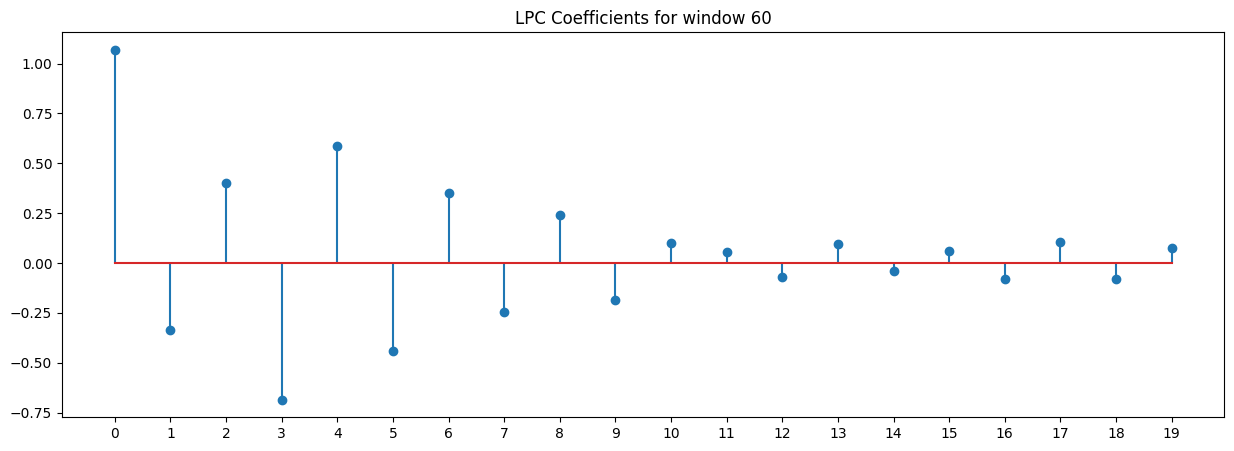

In [85]:
window_size = 0.025 # moving window size in seconds
overlap = 0.010 # overlap in seconds
window_len = int(window_size * fs)  # window length in samples
step = int(overlap * fs)  # step size in samples
window = np.hamming(window_len)
order = 20

lpc_coeffs = list()

for idx in range(0, len(audio_signal) - window_len, step):
    samples = audio_signal[idx:idx + window_len] * window
    lpc_coeffs.append(lpc_compute(samples, order=order))

sample2plot = 60

print(f'Number of windows: {len(lpc_coeffs)}')
print(lpc_coeffs[sample2plot])

plt.figure(figsize=(15, 5))
plt.stem(lpc_coeffs[sample2plot])
plt.xticks(np.arange(len(lpc_coeffs[sample2plot])))
plt.title(f'LPC Coefficients for window {sample2plot}')
plt.show()


Ejercicio 10

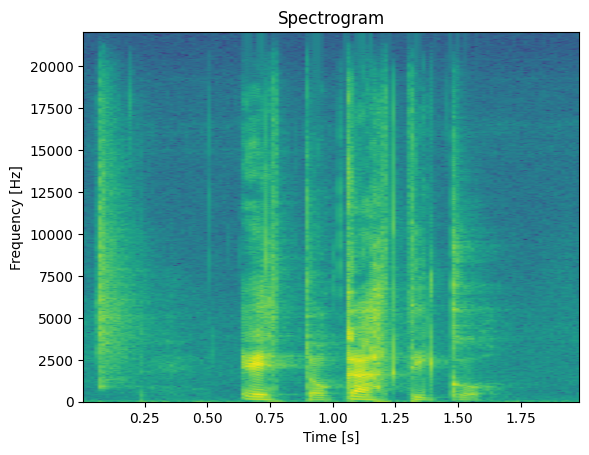

In [95]:
plt.specgram(
    audio_signal, NFFT=len(window), Fs=fs, noverlap=step, window=window)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Spectrogram')
plt.show()

Ejercicio 11